In [1]:
import numpy as np
import PIL.Image as Image
from transformers import SamModel, SamConfig, SamProcessor, pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
import cv2
from sklearn.cluster import DBSCAN
import time

def hdr_to_rgb(hdr_image: np.ndarray) -> np.ndarray:
    img_normalized = cv2.normalize(hdr_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
    brightness_factor = 1
    return np.clip(img_rgb * brightness_factor, 0, 255).astype(np.uint8)

/Users/tiger/anaconda3/envs/DING-LAB-FISH/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"
model = SamModel(config=SamConfig.from_pretrained("facebook/sam-vit-base"))
model.load_state_dict(torch.load("./assets/model/fish_v3.50.pth", map_location=torch.device(device)))
# model = SamModel.from_pretrained("facebook/sam-vit-huge")
model.to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
raw_img = np.array(Image.open("/Users/tiger/Documents/Github/FISH-ML/assets/demoTif/1-50_Hong/MAX_KOa_w1-359 DAPI_s012.tif"))

/var/folders/vn/h48p34010qv8xcjpg0fqf3x80000gn/T/ipykernel_68207/750583824.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./assets/mod

In [3]:
img = hdr_to_rgb(raw_img)

# input_points shape: (batch_size, point_batch_size, num_points_per_image, 2)
input_points = [
    # batch_size = 1 (only 1 image)
    [
        # point_batch_size = 2 (2 differnt segment)
        # the first segment
        [
            # num_points_per_image = 1 (only 1 point for current segment)
            [490,1160],# shape: (3,) x,y,positive|negative
        ],
        # the second segment
        [
            [340,1098],
        ]
    ]
]

print("INPUT:", torch.tensor(input_points).shape)

INPUT: torch.Size([1, 2, 1, 2])


In [4]:
inputs = processor(img,
                   input_points = input_points,
                   return_tensors="pt",
                   do_convert_rgb=False).to(device)
model.eval()
with torch.no_grad():
    outputs: dict = model(**inputs, multimask_output=False)
    print("OUTPUT: ", outputs["pred_masks"].shape)
    # OUTPUTS SHAPE: (batch, segment, multioutput, x, y)
    # !!!out application: torch.Size([1, bbox, 1, 256, 256]) be4 squeeze
    # if multimask, 1 N 3 256 256

OUTPUT:  torch.Size([1, 2, 1, 256, 256])


In [5]:
masks: list = processor.image_processor.post_process_masks(masks=outputs.pred_masks.cpu(),
                                                           original_sizes=inputs["original_sizes"].cpu(),
                                                           reshaped_input_sizes=inputs["reshaped_input_sizes"].cpu(),)  
masks = masks[0].squeeze(1).numpy().astype(np.uint8)
# N 2048 2048
print("SQUZ: ", masks.shape)

SQUZ:  (2, 2048, 2048)


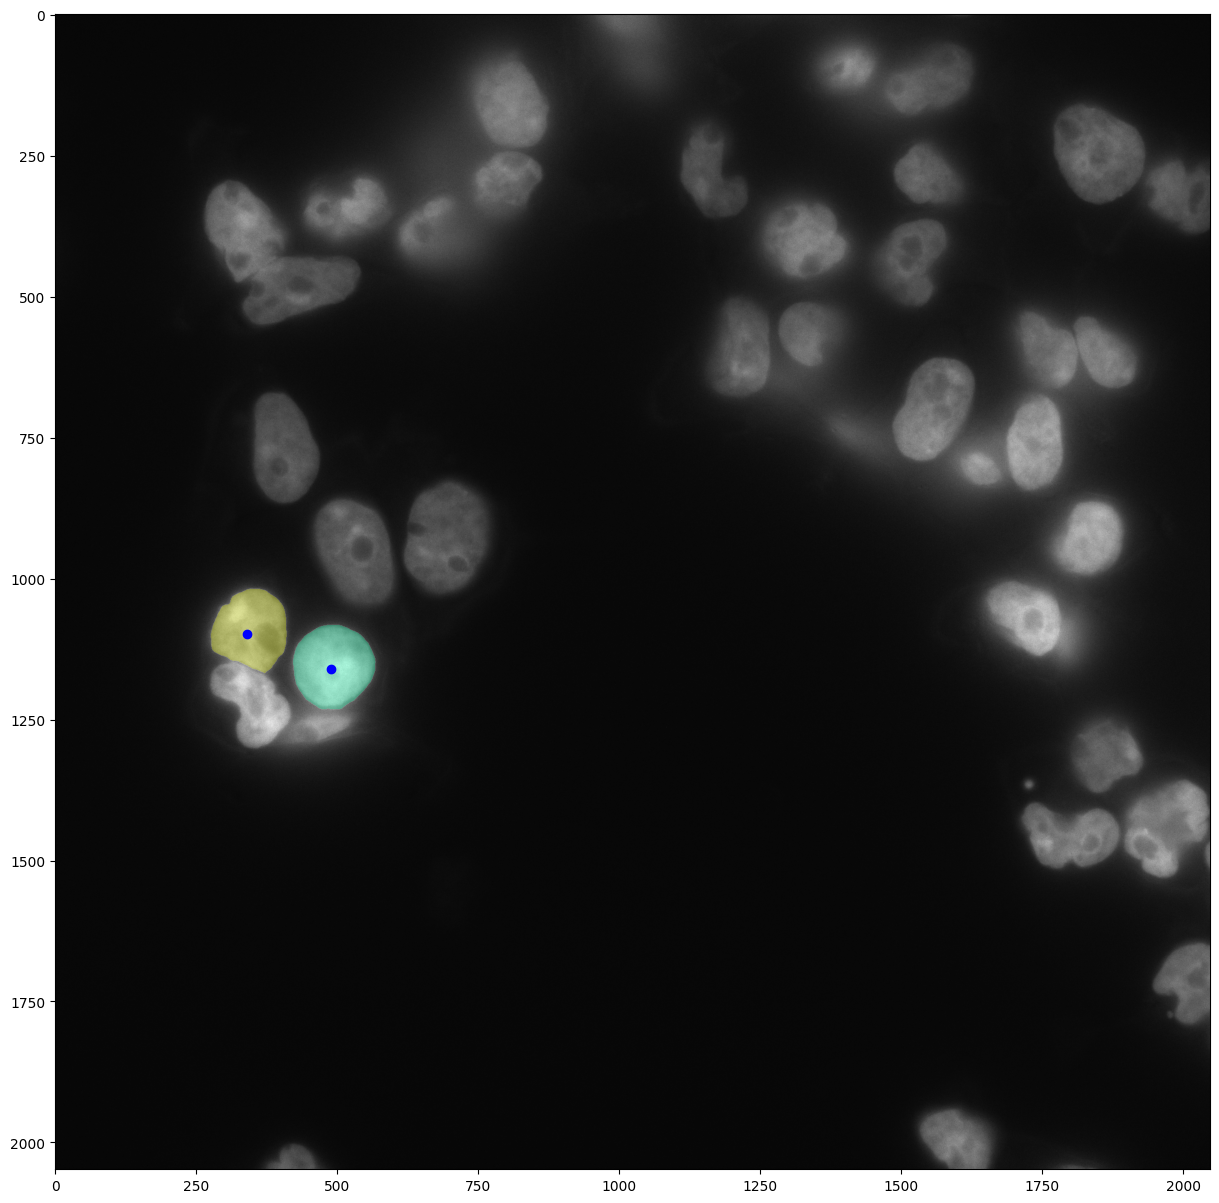

In [6]:
_, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, cmap='gray')
for i in input_points[0]:
    ax.plot(i[0][0], i[0][1], 'bo')

overlay = np.ones((2048, 2048, 4))
overlay[:,:,3] = 0
for i in masks:
    color_mask = np.concatenate([np.random.random(3), [0.35]])
    overlay[i > 0] = color_mask
ax.imshow(overlay)

plt.show()

In [7]:
img_int8 = cv2.normalize(raw_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
edges = cv2.Canny(img_int8, threshold1=35, threshold2=45)
edge_points = np.column_stack(np.where(edges > 0))

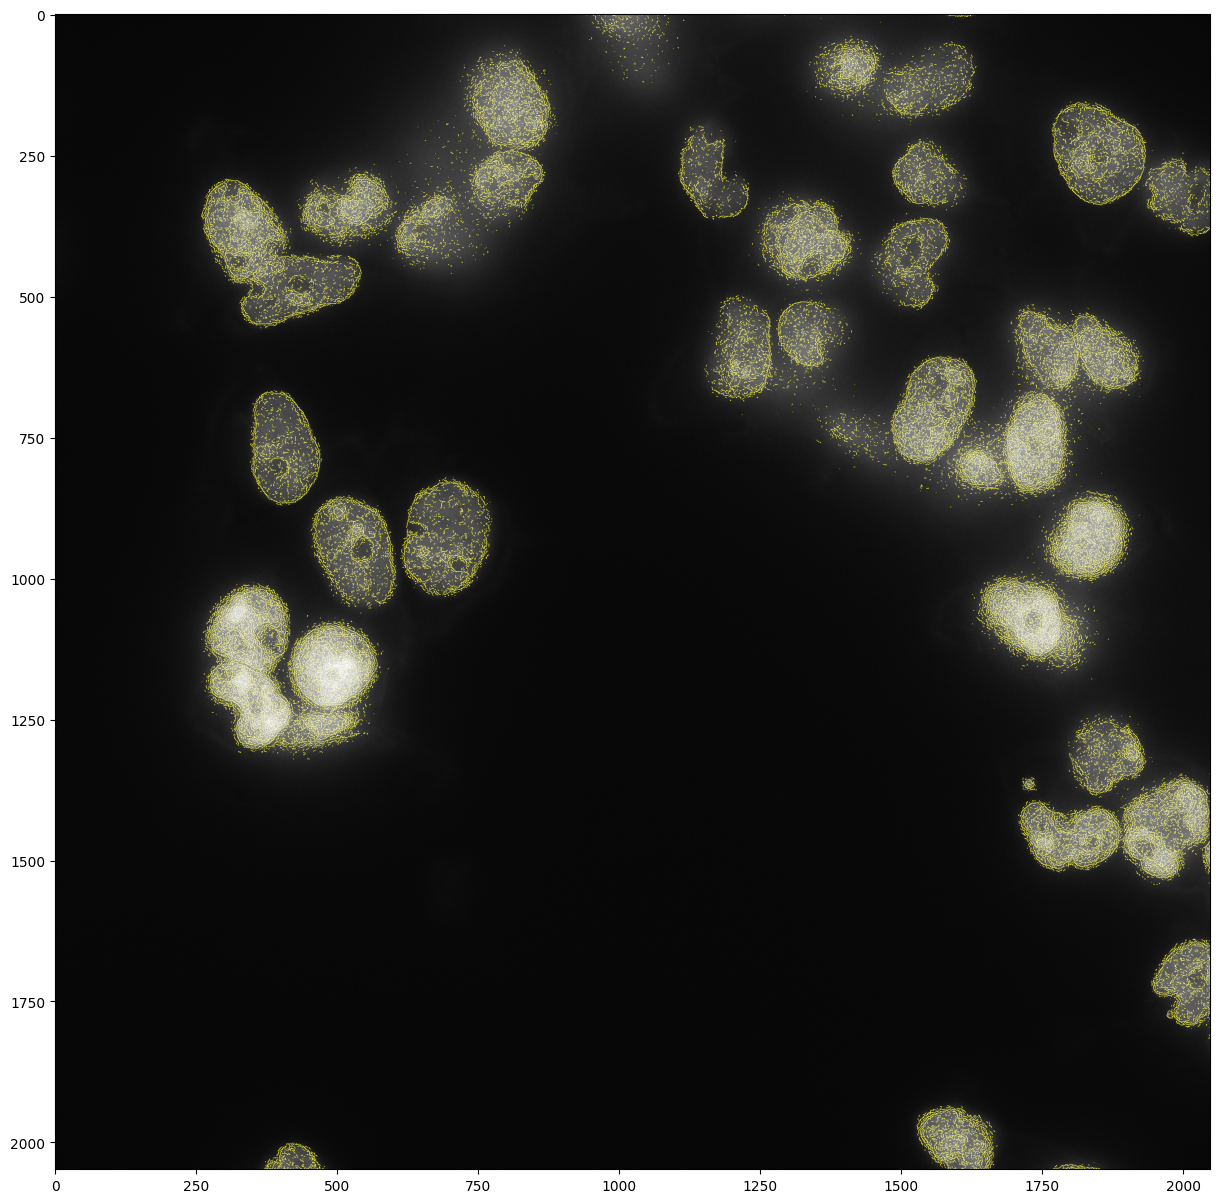

In [8]:
edge_image = np.zeros((raw_img.shape[0], raw_img.shape[1], 3), dtype=np.uint8)
for point in edge_points:
    edge_image[point[0], point[1]] = [255, 255, 0]
combined_image = cv2.addWeighted(hdr_to_rgb(raw_img), 1, edge_image, 1, 0)

plt.figure(figsize=(15, 15))
plt.imshow(combined_image)
plt.show()

In [9]:
dbscan = DBSCAN(eps=30, min_samples=200).fit(edge_points)
labels = dbscan.labels_

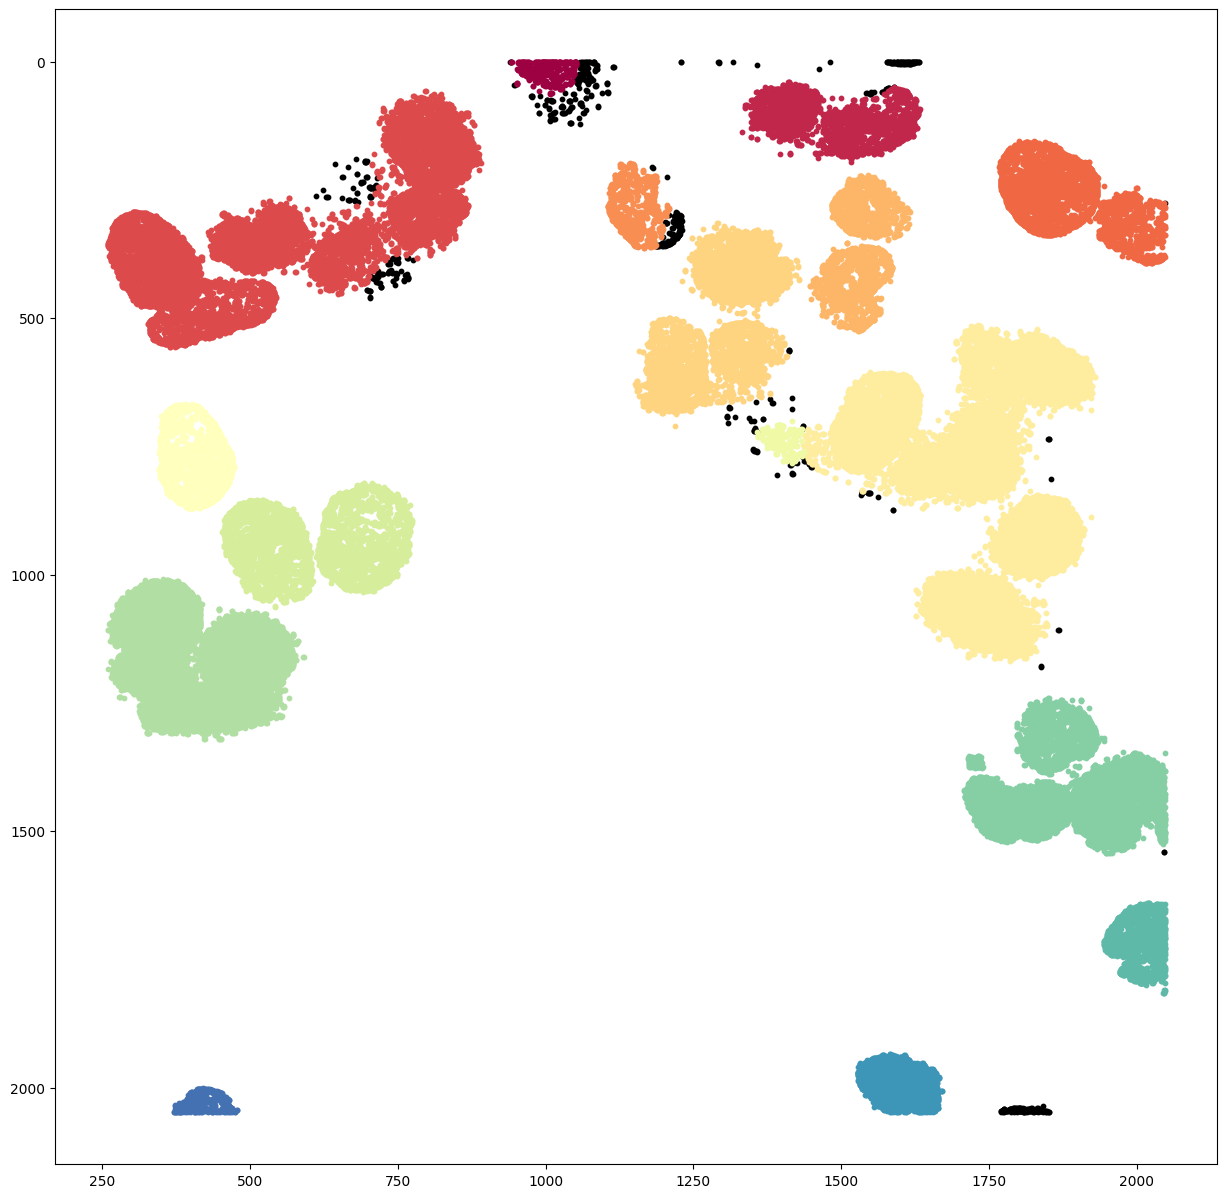

In [10]:
plt.figure(figsize=(15, 15))
for label in np.unique(labels):
    if label == -1:
        color = 'k'
    else:
        color = plt.cm.Spectral(label / np.max(labels + 1))
    cluster = edge_points[labels == label]
    plt.scatter(cluster[:, 1], cluster[:, 0], s=10, c=[color])
plt.gca().invert_yaxis()
plt.show()

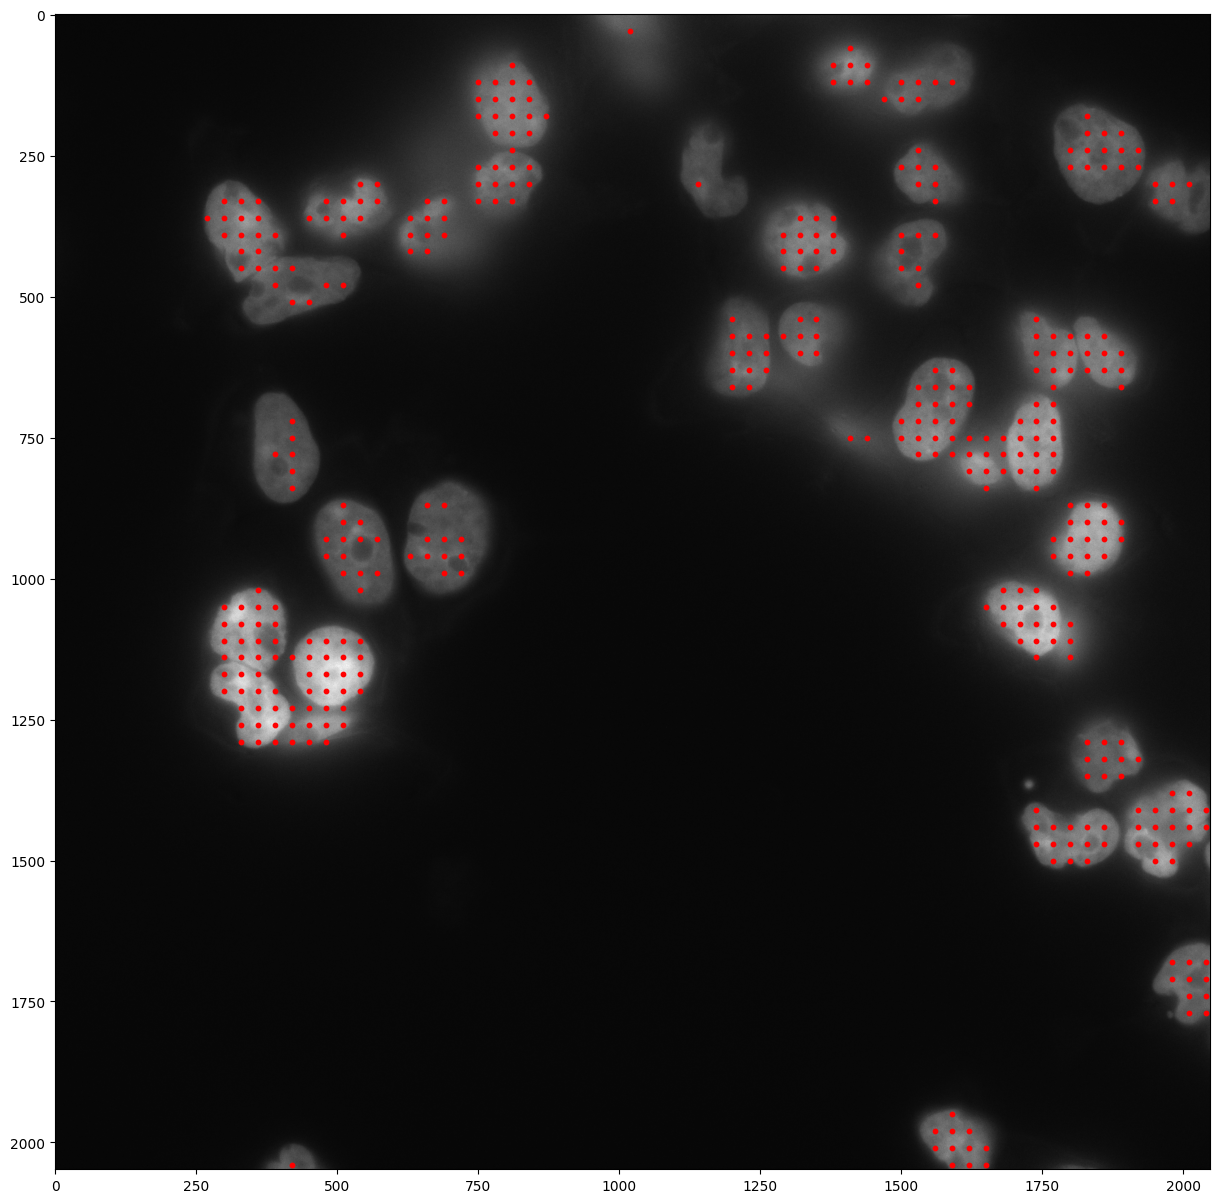

(414, 2)


In [11]:
image_size = (2048, 2048)
r = np.arange(0, 2048, 30)
x_grid, y_grid = np.meshgrid(r, r)
points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
points = points[(points[:, 0] != 0) & (points[:, 1] != 0)]

brightness_threshold = 80
selected_points = []
for x, y in points:
    r, g, b = img[y, x]
    brightness = 0.299 * r + 0.587 * g + 0.114 * b
    if brightness > brightness_threshold:
        selected_points.append((x, y))

points = np.array(selected_points)

_, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, cmap='gray')
plt.scatter(points[:, 0], points[:, 1], color='red', s=10)
plt.show()
print(points.shape)


Batch size: 414
Reshaped points shape: torch.Size([414, 1, 1, 1, 2])
Batch 1 done.
Batch 3 done.
Batch 2 done.
Batch 0 done.
Batch 4 done.
Batch 5 done.
Batch 6 done.
Batch 7 done.
Batch 8 done.
Batch 9 done.
Batch 10 done.
Batch 11 done.
Batch 12 done.
Batch 14 done.
Batch 17 done.
Batch 13 done.
Batch 15 done.
Batch 18 done.
Batch 16 done.
Batch 19 done.
Batch 20 done.
Batch 23 done.
Batch 22 done.
Batch 21 done.
Batch 26 done.
Batch 25 done.
Batch 24 done.
Batch 28 done.
Batch 27 done.
Batch 29 done.
Batch 31 done.
Batch 32 done.
Batch 34 done.
Batch 30 done.
Batch 33 done.
Batch 35 done.
Batch 36 done.
Batch 37 done.
Batch 38 done.
Batch 40 done.
Batch 39 done.
Batch 41 done.
Batch 42 done.
Batch 43 done.
Batch 45 done.
Batch 44 done.
Batch 46 done.
Batch 47 done.
Batch 49 done.
Batch 48 done.
Batch 50 done.
Batch 51 done.
Batch 52 done.
Batch 53 done.
Batch 54 done.
Batch 56 done.
Batch 55 done.
Batch 58 done.
Batch 57 done.
Batch 59 done.
Batch 60 done.
Batch 61 done.
Batch 62 do

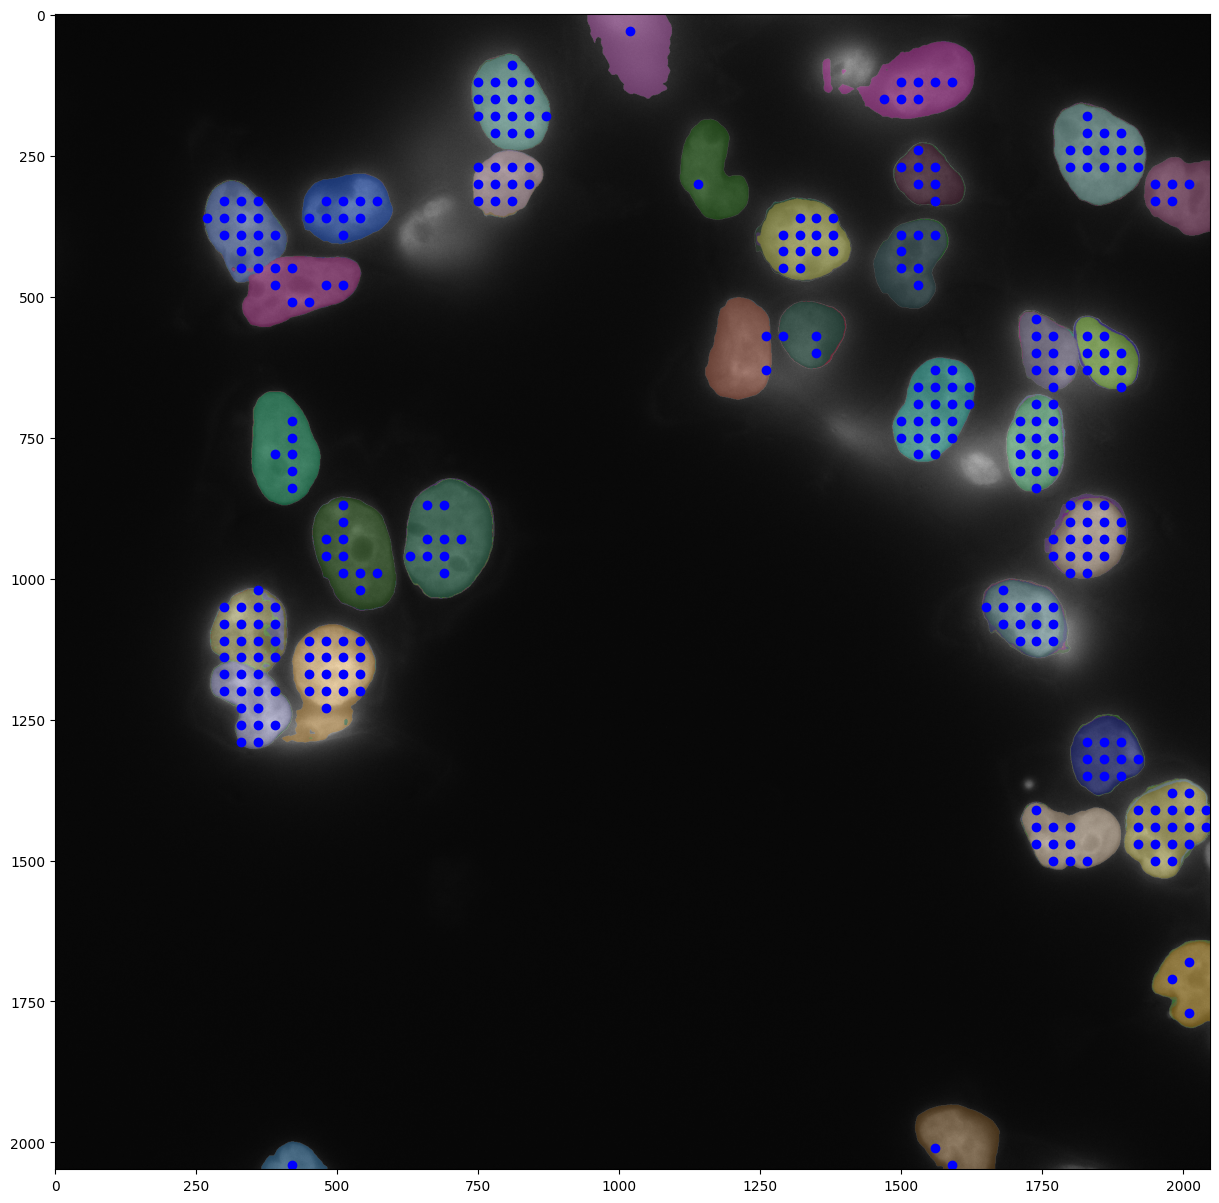

In [12]:
reshaped_points = points.reshape(points.shape[0], 1, 1, 1, points.shape[1]).astype(float).tolist()
batch_size = len(reshaped_points)
print("Batch size:", batch_size)
print("Reshaped points shape:", torch.tensor(reshaped_points).shape)
inputs = processor(img, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

def pSingle(points_current_batch, batch_no, iou_threshold=0.8):
    inputs = processor(img,
                       input_points = points_current_batch,
                       return_tensors="pt",
                       do_convert_rgb=False).to(device)
    
    inputs.pop("pixel_values", None)
    inputs.update({"image_embeddings": image_embeddings})
    
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
        print(f"Batch {batch_no} done.")
        
    iou_scores = outputs["iou_scores"].cpu()
    
    if torch.any(iou_scores >= iou_threshold):
        masks: list = processor.image_processor.post_process_masks(masks=outputs.pred_masks.cpu(),
                                                                   original_sizes=inputs["original_sizes"].cpu(),
                                                                   reshaped_input_sizes=inputs["reshaped_input_sizes"].cpu(),)  
        masks = masks[0].squeeze(1)
        return masks, points_current_batch
    return None
    

results = []
results_points = []

start_time = time.time()
with ThreadPoolExecutor(max_workers=12) as executor:
    futures = [executor.submit(pSingle, reshaped_points[i], i) for i in range(batch_size)]
    
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            results.append(result[0])
            results_points.append(result[1])

end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

final_masks = torch.cat(results, dim=0).numpy().astype(np.uint8)

print("All predictions done.")
print("Final masks shape:", final_masks.shape)

_, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, cmap='gray')
results_points = np.array(results_points)
results_points = results_points.reshape(results_points.shape[0], 2)
for i in results_points:
    ax.plot(i[0], i[1], 'bo')
    
overlay = np.ones((2048, 2048, 4))
overlay[:,:,3] = 0
for i in final_masks:
    color_mask = np.concatenate([np.random.random(3), [0.35]])
    overlay[i > 0] = color_mask
ax.imshow(overlay)

plt.show()


In [24]:
def fish_predict(processor, model, device: str, img: np.ndarray, input_points: np.ndarray, input_labels: np.ndarray=None, iou_th: float=0.0) -> tuple:
    """FISH Finetuned Model Prediction

    Args:
        processor (Any): SAM Processor from hugging face
        model (Any): SAM Model with updated weights and state dict
        device (str): cpu or cuda
        img (np.ndarray): input image in rgb format (3channel)
        input_points (np.ndarray): (batch_size, point_batch_size, num_points_per_image, 2)
        input_labels (np.ndarray): (batch_size, point_batch_size, num_points)
        iou_th (float): iou threshold, only export >= threshold

    Returns:
        tuple: masks, iou_scores, result_points
    """
    
    def run(processor, model, device: str, img: np.ndarray, input_points: np.ndarray, input_labels: np.ndarray=None, iou_th: float=0.0) -> tuple:
        """Executer Wrapper
        Return masks in shape (1,N,1,256,256)

        Returns:
            tuple: masks, iou_scores, result_point
        """ 
        # Prepare
        inputs = processor(img,
            input_points = input_points.tolist(),
            return_tensors="pt",
            do_convert_rgb=False,
            input_labels=input_labels.tolist() if input_labels is not None else None,
        ).to(device)
        inputs.pop("pixel_values", None)
        inputs.update({"image_embeddings": image_embeddings})
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            outputs: dict = model(**inputs, multimask_output=False)
        iou_scores = outputs["iou_scores"].cpu()
        
        # Apply Filter
        if torch.any(iou_scores >= iou_th):
            return outputs["pred_masks"], iou_scores, input_points[0,0,0].reshape(2)
        return None
    
    emb_proc = processor(img, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(emb_proc["pixel_values"])
    batch_size = input_points.shape[1]
    
    masks = []
    iou_scores = []
    result_points = []
    with ThreadPoolExecutor(max_workers=12) as executor:
        futures = [
            executor.submit(run, processor, model, device, img, input_points[:,i:i+1,:,:], input_labels[:,i:i+1,:], iou_th) for i in range(batch_size)
        ]
        
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                masks.append(result[0])
                iou_scores.append(result[1])
                result_points.append(result[2])
    
    merged_tensor = None # 1 N 1 256 256
    if masks:
        merged_tensor = torch.cat(masks, dim=1)
    
    if merged_tensor is not None:
        masks: list = processor.image_processor.post_process_masks(
            masks=merged_tensor,
            original_sizes=inputs["original_sizes"].cpu(),
            reshaped_input_sizes=inputs["reshaped_input_sizes"].cpu(),
        )  
        masks = masks[0].squeeze(1).numpy().astype(np.uint8) # N 2048 2048
    
    return masks, iou_scores, result_points

In [42]:
input_points = points.reshape(1, points.shape[0], 1, points.shape[1]) # 1 N 1 2
ex = np.array([1000,1000]).reshape(1,1,1,2)
input_points = np.concatenate((input_points, np.repeat(ex, input_points.shape[1], axis=1)), axis=2) # 1 N 2 2
single_label = np.array([1,0])
input_labels = np.tile(single_label, (1, input_points.shape[1], 1)).reshape(1, input_points.shape[1], 2) # 1 N 2

masks, iou_scores, results_points = fish_predict(processor, model, device, img, input_points, input_labels, 0.7)


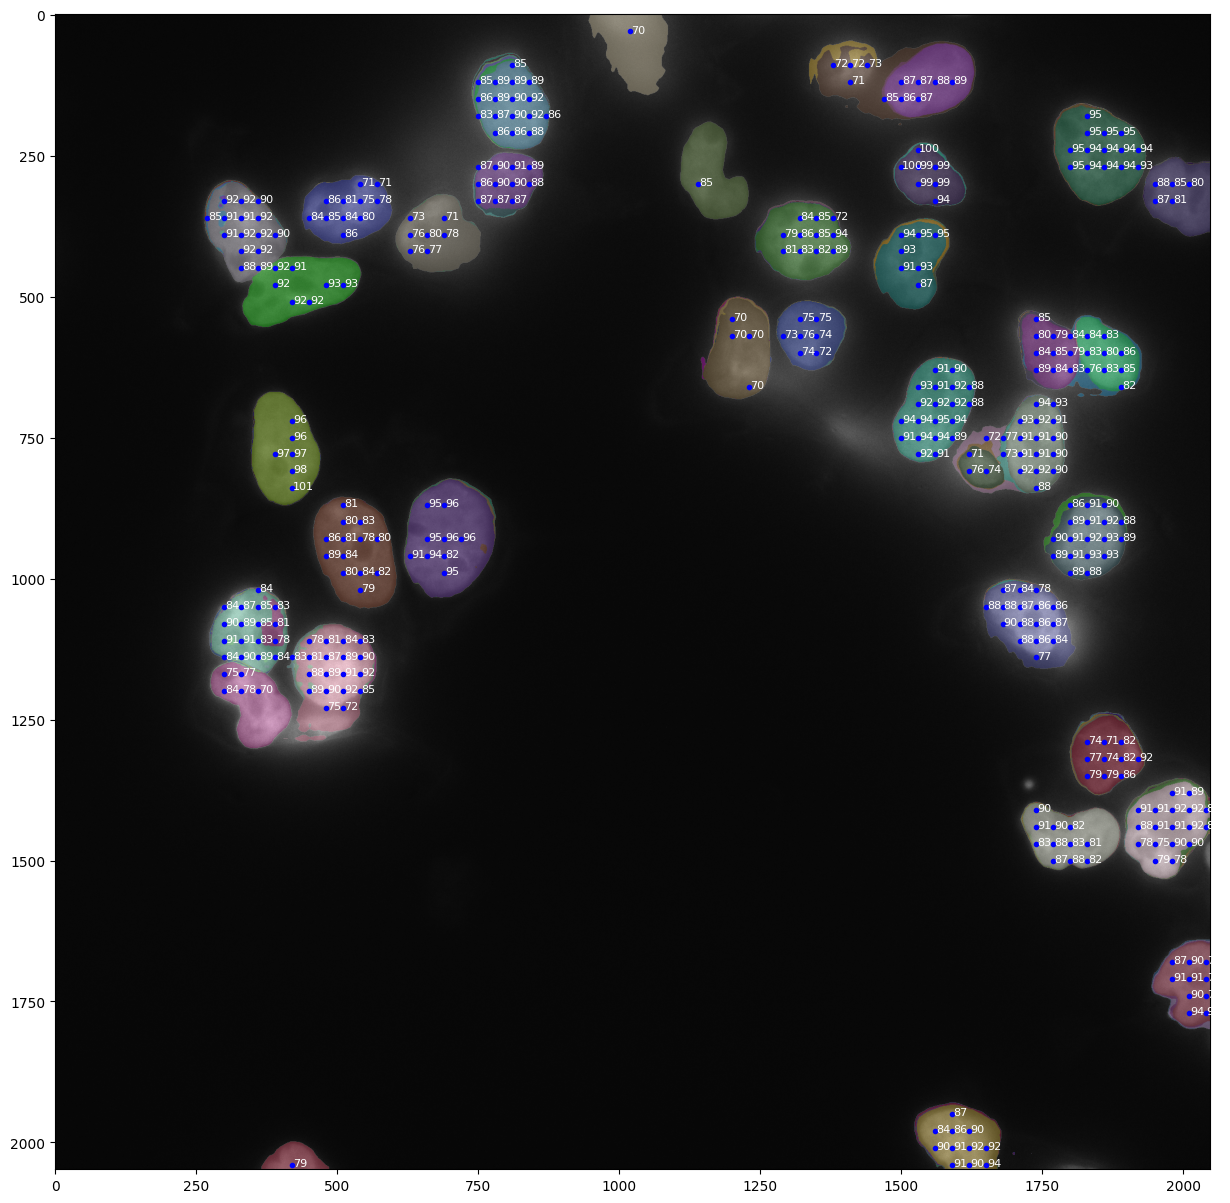

In [43]:
_, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, cmap='gray')
for i in range(len(results_points)):
    ax.plot(results_points[i][0], results_points[i][1], 'bo', markersize=3)
    ax.text(results_points[i][0] + 2, results_points[i][1] + 2, f"{int(iou_scores[i][0,0,0]*100)}", color='white', fontsize=8)
    
overlay = np.ones((2048, 2048, 4))
overlay[:,:,3] = 0
for i in masks:
    color_mask = np.concatenate([np.random.random(3), [0.35]])
    overlay[i > 0] = color_mask
ax.imshow(overlay)

plt.show()